# 23. Convolutional AutoEncoder

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np
import random
import os

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## Load MNIST Data

In [3]:
mnist_train = dsets.MNIST(root='data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

In [4]:
batch_size = 100

train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                          batch_size=1,
                                          shuffle=False)

In [5]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

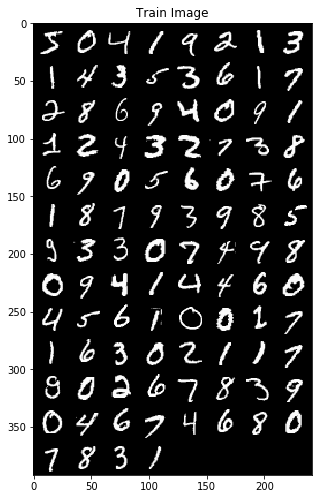

In [6]:
images, labels = iter(train_loader).next()
imshow(torchvision.utils.make_grid(images, normalize=True), "Train Image")

## Define Model

In [7]:
# N: input, F: filter, P: padding, S: stride

def c_conv(N, F, P=0, S=1):
    return int((N+2*P-F)/S+1)

def c_pool(N, F):
    return int(N/F)

# Transposed convolution
def t_conv(N, F, P=0, S=1):
    return int(S*(N-1)+F-2*P)

In [8]:
# Encoder
c0 = 28
c1 = c_conv(c0, 5)
c2 = c_conv(c1, 5)
c3 = c_pool(c2, 2)
c4 = c_conv(c3, 5)
c5 = c_pool(c4, 2)

print(c1, c2, c3, c4, c5)

24 20 10 6 3


In [9]:
# Decoder
c0 = 3
c1 = t_conv(c0, 5, 1, 2)
c2 = t_conv(c1, 4, 1, 2)
c3 = t_conv(c2, 4, 1, 2)

print(c1, c2, c3)

7 14 28


In [10]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1,16,5),    # 28 --> 24
            nn.BatchNorm2d(16),
            nn.ReLU(),            
            
            nn.Conv2d(16,32,5),   # 20
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2),    # 10
            
            nn.Conv2d(32,64,5),   # 6
            nn.ReLU(),
            nn.MaxPool2d(2,2)     # 64*3*3
        )
        
    def forward(self, x):
        z = self.encoder(x)
        
        return z

In [11]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64,32,5,stride=2,padding=1),
            nn.BatchNorm2d(32),
#             nn.MaxUnpool2d(2,2),
            nn.ReLU(),
            
            nn.ConvTranspose2d(32,16,4,stride=2,padding=1),
            nn.BatchNorm2d(16),
#             nn.MaxUnpool2d(2,2),
            nn.ReLU(),
            
            nn.ConvTranspose2d(16,1,4,stride=2,padding=1),
            nn.ReLU()
        )
        
    def forward(self, z):
        out = self.decoder(z)
        out = out.view(-1,1,28,28)
        
        return out

In [12]:
E = Encoder().cuda()
D = Decoder().cuda()

## Training

In [13]:
loss = nn.MSELoss()

# 2개의 모델을 함께 학습시킴
optimizer = optim.Adam(list(E.parameters()) + list(D.parameters()), lr=0.001)

In [14]:
num_epochs = 10

for epoch in range(num_epochs):
    
    total_batch = len(mnist_train) // batch_size
    
    for i, (batch_images, batch_labels) in enumerate(train_loader):
        
        X = batch_images.cuda()
        
        pred = D(E(X))        # 2개의 모델을 함께 학습시킴
        cost = loss(pred, X)
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        if (i+1) == total_batch:
            print('Epoch [%d/%d], lter [%d/%d] Loss: %.4f'%(epoch+1, num_epochs, i+1, total_batch, cost.item()))
    
print("Learning Finished!")

Epoch [1/10], lter [600/600] Loss: 0.0185
Epoch [2/10], lter [600/600] Loss: 0.0141
Epoch [3/10], lter [600/600] Loss: 0.0116
Epoch [4/10], lter [600/600] Loss: 0.0102
Epoch [5/10], lter [600/600] Loss: 0.0089
Epoch [6/10], lter [600/600] Loss: 0.0079
Epoch [7/10], lter [600/600] Loss: 0.0071
Epoch [8/10], lter [600/600] Loss: 0.0065
Epoch [9/10], lter [600/600] Loss: 0.0061
Epoch [10/10], lter [600/600] Loss: 0.0057
Learning Finished!


## Test

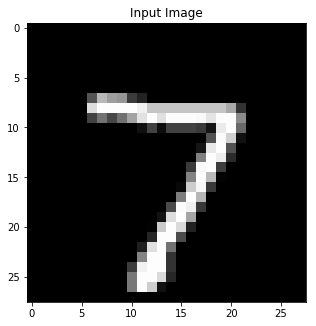

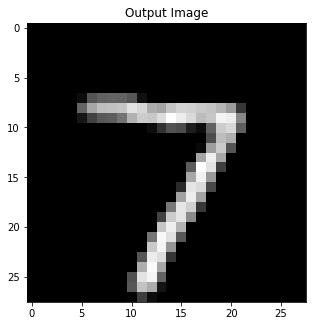

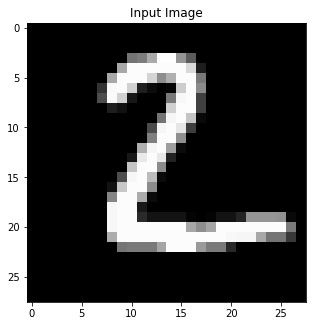

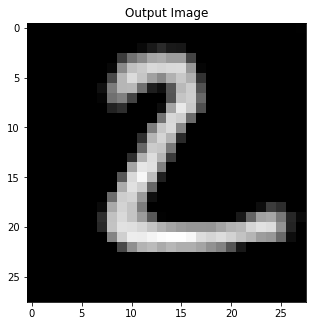

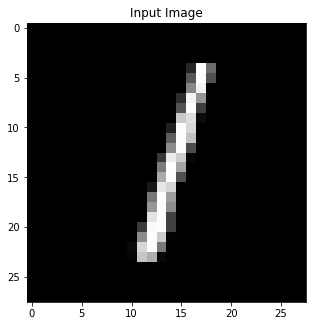

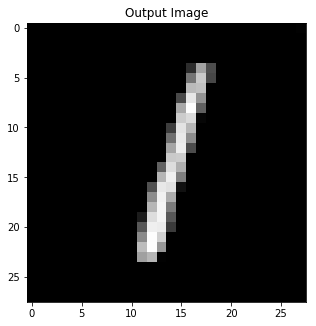

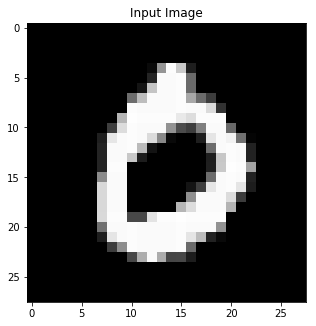

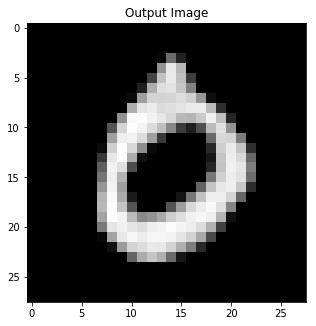

In [15]:
E.eval()
D.eval()

for n, (images, labels) in enumerate(test_loader):
    
    imshow(torchvision.utils.make_grid(images, normalize=True), "Input Image")
    images = images.view(-1, 1, 28, 28).cuda()
    
    outputs = D(E(images))
    outputs = outputs.view(-1, 1, 28, 28)
    
    imshow(torchvision.utils.make_grid(outputs.data.cpu(), normalize=True), "Output Image")
    
    if n > 2 : break

## Make Random Image

torch.Size([1, 64, 3, 3])


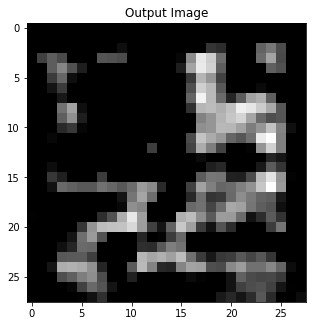

In [16]:
z = torch.rand(E(images).size()).cuda()
print(z.size())

outputs = D(z)
outputs = outputs.view(-1, 1, 28, 28)

imshow(torchvision.utils.make_grid(outputs.data.cpu(), normalize=True), "Output Image")